In [3]:
!ls ../new_data5/test/face -1 | wc -l
!ls ../new_data5/test/non-face -1 | wc -l
!ls ../new_data5/train/face -1 | wc -l
!ls ../new_data5/train/non-face -1 | wc -l

905
1810
3618
7236


In [4]:
import sys; sys.path.append("../")
from feature_extractor import FeatureExtractor
import torch
import numpy as np
import time
from cascade import CascadeClassifier
import cv2

In [5]:
torch.cuda.is_available()

True

In [6]:
parent = '../hFeatures5_2/'
data_path = 'new_data5'

# Features Extraction

In [7]:
mean = 111.02404842061983
std = 56.926623499738575

In [8]:
def transform1(img):
  return img
  # img = (img - img.mean()) / (img.std() + 1e-8)
  # return cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [60]:

feature_extractor = FeatureExtractor(shape=(19,19),
                                     percentile=20,
                                     all_features_file=parent + "all_features.npz",
                                     selected_features_file=parent + "selected_features.npz",
                                     labels_file=parent + "labels.npy",
                                     indecies_file=parent + "indecies.npy",)

In [10]:

X, y = feature_extractor.extractFeatures(pos_path='../'+data_path+'/train/face',
                                  neg_path='../'+data_path+'/train/non-face',
                                  transform=transform1,
                                  save_to_file=False)
print('done')


all_features shape: (63960, 10854)
done


In [11]:
# del feature_extractor.f2
# del feature_extractor.f3
# del feature_extractor.f4

In [12]:
indecies, X = feature_extractor.selectPercentile(X, y )
# y = np.load(parent + 'labels.npy')
print(X.shape, y.shape)
print('done')


Now selecting percentile features
(12792, 10854) (10854,)
done


In [13]:
# temp = np.load('../hFeatures3/all_features.npz')['arr_0']
temp = X
temp

array([[  12.,  -99.,   33., ...,    9.,   77.,   10.],
       [ 165., -116.,   89., ...,   16.,  122.,   19.],
       [  10.,   28.,  -18., ...,    7.,   10.,    0.],
       ...,
       [ -13., -100.,  -12., ...,    2.,    0.,    3.],
       [  30., -157.,  -33., ...,    2.,    0.,    7.],
       [  38.,  -67.,  -22., ...,    1.,   -1.,    4.]], dtype=float32)

In [14]:
print(temp.min())
print(temp.max())
print(temp[3])
print(temp[4])

-26151.0
29662.0
[ 423. -123.  251. ...   20.  144.   25.]
[ 12.  41. -21. ...   8.  12.   0.]


# Training

In [15]:
[20]*10

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

In [19]:
X.shape

(10854, 12792)

In [21]:
import multiprocessing
multiprocessing.cpu_count()

2

In [25]:
# adaboost from sklearn with base_estimator = DecisionTreeClassifier with max_depth = 1 (stump) and n_estimators = 200
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Take X.T because sklearn expects (n_samples, n_features)
X = X.T
y = y.T


print(X.shape, y.shape)

s_t = time.time()

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
clf.fit(X, y)

print('time:', time.time() - s_t)


(10854, 12792) (10854,)
time: 2286.144472837448


In [26]:
# %rm StrongClassifier/lastSC.last
# s_t = time.time()
# cascadeClassifier= CascadeClassifier(X, y, batchsize=5000, verbose=True, layers=[200])
# tr_acc = cascadeClassifier.train()

# cascadeClassifier.save(parent + 'cascadeClassifier.pkl')

# print('accuracy: ', tr_acc)
# print('time taken: ', time.time() - s_t, 's')
# print('done')

# Testing

In [27]:
# accuracy imports
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [31]:
X_test, y_test = feature_extractor.extractFeatures(pos_path='../'+data_path+'/test/face',
                                  neg_path='../'+data_path+'/test/non-face',
                                  transform=transform1,
                                  save_to_file=False)
print('done')


all_features shape: (63960, 2715)
done


In [35]:
X_test.shape

(63960, 2715)

In [36]:
X_test = X_test[indecies]

# convert from torch to numpy and take transpose
X_test = X_test.T

print(X_test.shape, y_test.shape)
print('done')


(2715, 12792) (2715,)
done


In [37]:
# Test accuracy
y_pred = clf.predict(X_test)


In [39]:
# s_t = time.time()
# t_f_idx_map, t_features, t_labels = feature_extractor.extractFeaturesByIndecies(pos_path='../'+data_path+'/test/face',
#                                             neg_path='../'+data_path+'/test/non-face',
#                                             cascadeClassifier=cascadeClassifier,
#                                             transform=transform1)
# print(t_features.shape, t_labels.shape)
# predictions = cascadeClassifier.predict(t_features, t_f_idx_map)
# print('test accuracy: ', np.sum(predictions == t_labels) / t_labels.shape[0])
# print('time taken: ', time.time() - s_t, 's')

In [38]:
# report
print('accuracy: ', accuracy_score(y_test, y_pred))
print('f1 score macro: ', f1_score(y_test, y_pred, average='macro'))
print('f1 score binary: ', f1_score(y_test, y_pred, average='binary'))
print('f1 score micro: ', f1_score(y_test, y_pred, average='micro'))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('classification report: \n', classification_report(y_test, y_pred, digits=4))


accuracy:  0.9775322283609577
f1 score macro:  0.9746745957362672
f1 score binary:  0.9661674986134222
f1 score micro:  0.9775322283609577
precision:  0.9699331848552338
recall:  0.9624309392265193
confusion matrix: 
 [[1783   27]
 [  34  871]]
classification report: 
               precision    recall  f1-score   support

           0     0.9813    0.9851    0.9832      1810
           1     0.9699    0.9624    0.9662       905

    accuracy                         0.9775      2715
   macro avg     0.9756    0.9738    0.9747      2715
weighted avg     0.9775    0.9775    0.9775      2715



In [40]:
from joblib import dump, load
dump(clf, '../hFeatures5_2/clf.joblib')


['../hFeatures5_2/clf.joblib']

# Try full image

In [41]:
# !mkdir /content/drive/MyDrive/GP/GP_try/hFeatures5_2
# !cp -r ../hFeatures5_2/* /content/drive/MyDrive/GP/GP_try/hFeatures5_2

In [42]:
# !mkdir ../../lfw_all
# !cp /content/drive/MyDrive/GP/lfw_all/* ../../lfw_all/

In [43]:
import random
from detect_face import find_face
from PIL import Image
import os
import matplotlib.pyplot as plt
lfw_all = '../../lfw_all/'
all_images_names = os.listdir(lfw_all)
# all_images_names = sorted(all_images_names)
random.shuffle(all_images_names)
all_images_names = [lfw_all + name for name in all_images_names]
all_images_names[0]

'../../lfw_all/Billy_Crystal_0003.jpg'

In [67]:
show_images = list(range(0, 5))
rectangles_only = True
# resize_to = (100, 100)
random.shuffle(all_images_names)

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [69]:
feature_extractor.verbose = False

RGB
(250, 250)
{'Getting Subwindows': 0.22074222564697266, 'Resizing Subwindows': 0.3468506336212158, 'Normalize': 1.3828277587890625e-05, 'Extracting Features': 6.0123069286346436, 'Classifying': 85.98034906387329}


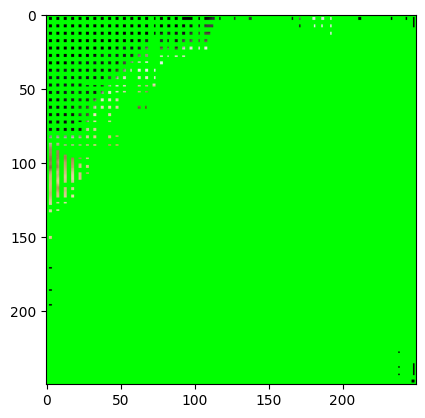

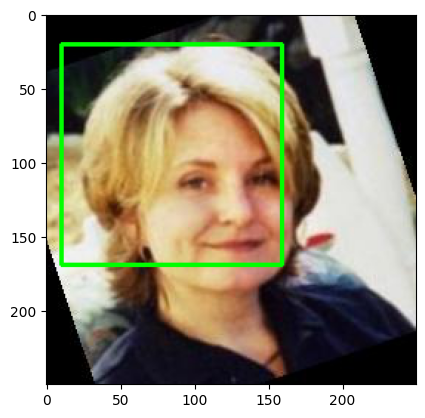

RGB
(250, 250)
{'Getting Subwindows': 0.1886758804321289, 'Resizing Subwindows': 0.34243154525756836, 'Normalize': 1.3828277587890625e-05, 'Extracting Features': 5.711680889129639, 'Classifying': 85.74143576622009}


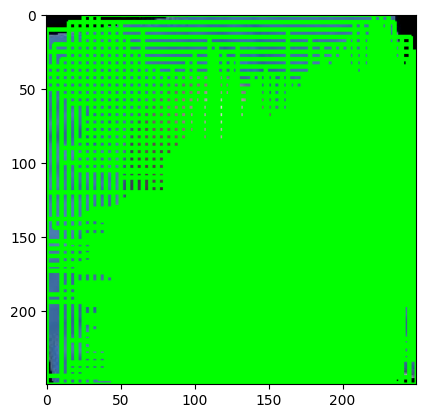

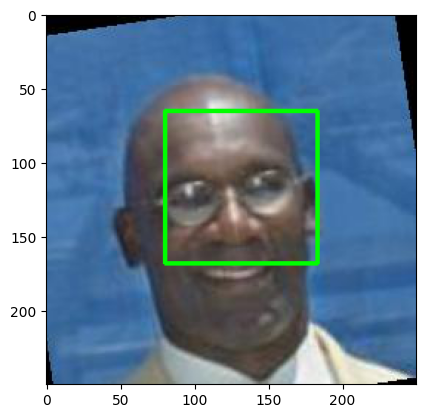

RGB
(250, 250)
{'Getting Subwindows': 0.17412400245666504, 'Resizing Subwindows': 0.3482089042663574, 'Normalize': 1.4543533325195312e-05, 'Extracting Features': 5.7208943367004395, 'Classifying': 84.62100863456726}


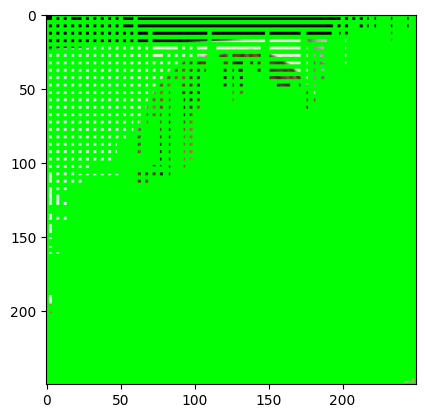

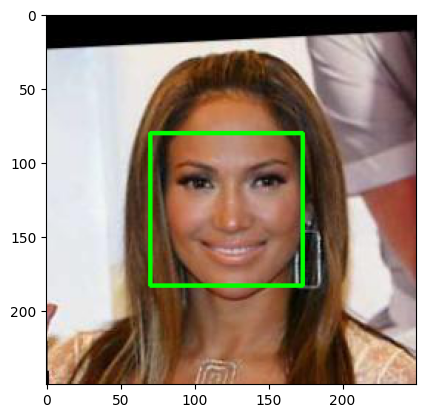

RGB
(250, 250)
{'Getting Subwindows': 0.13042712211608887, 'Resizing Subwindows': 0.34788036346435547, 'Normalize': 1.8835067749023438e-05, 'Extracting Features': 5.7193920612335205, 'Classifying': 85.25182390213013}


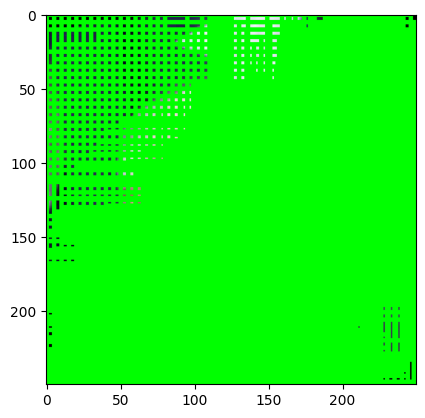

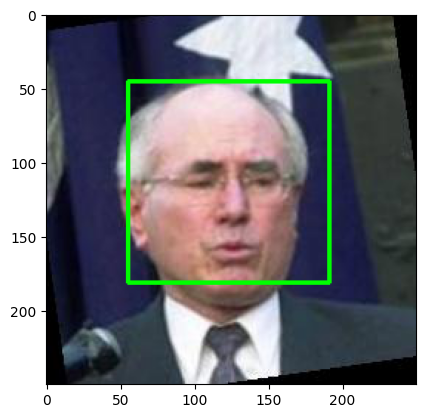

RGB
(250, 250)
{'Getting Subwindows': 0.13501667976379395, 'Resizing Subwindows': 0.32309389114379883, 'Normalize': 1.5020370483398438e-05, 'Extracting Features': 5.326087474822998, 'Classifying': 85.47792291641235}


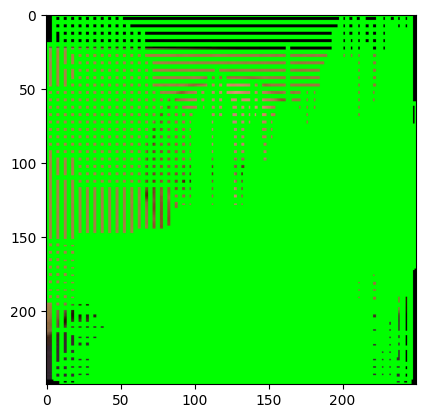

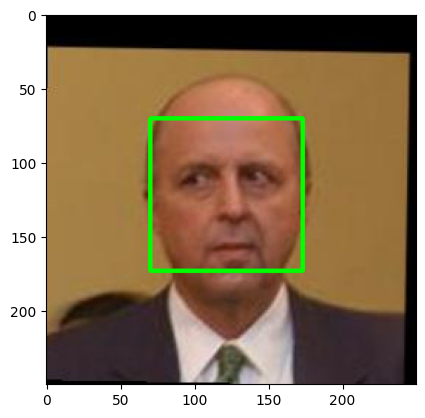

In [70]:
for i in show_images:
  # >>>> Read image <<<<
  img = Image.open(all_images_names[i])
  print(img.mode)
  img = np.array(img)
  org_sh = img.shape
  if not rectangles_only:
    plt.imshow(img)
    plt.show()
  # get subwindows
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(img2.shape)

  # >>>> Normalize image <<<<
  # normalize image
  # img2 = (img2 - img2.mean()) / img2.std()
  # img2 = cv2.resize(img, resize_to)
  # print(img2.shape)

  # img2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # resize image
  # img2 = cv2.resize(img2, (570, 380))

  # show image
  if not rectangles_only:
    plt.imshow(img2, cmap='gray')
    plt.show()

  # +++++++++++++++++++++
  # find face
  # >>>> Find face <<<<
  face_coordinates, region_max_conf, max_conf , timing=find_face(img2, \
                              clf, \
                              feature_extractor, \
                              window_size=(19, 19), \
                              scale_dist=1.1, \
                              max_size=300, \
                              stride=5, \
                              device=device, \
                              verbose=False,
                              report_time=True,
                              use_sklearn=True)
  print(timing)
  # region_max_conf *= img.shape[0] / resize_to[0]
  # ++++++++++++++++++++
  # rectangles
  # >>>> Draw rectangles <<<<
  tmp_img = img.copy()
  for face_coordinate in face_coordinates:
      for x1, y1, x2, y2 in face_coordinate:
          cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  # if not rectangles_only:
  plt.imshow(tmp_img)
  plt.show()

  # >>>> Draw rectangles with max confidence <<<<
  # amx confidence
  tmp_img = img.copy()
  x1, y1, x2, y2 = region_max_conf
  cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  plt.imshow(tmp_img)
  plt.show()

